In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import math
from multiprocessing import Pool
from tqdm import tqdm
from scipy import stats
## init
mySpecie='Homo_sapiens'
#prealigned_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.prealigned.pickle'
targetted_align_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.pickle'
manifest_dir='/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/./tcga_lgg_wgs_bams.df.wxs_rnaseq.pickle'

targetted_df=pd.read_pickle(targetted_align_dir).loc["TCGA"]

In [4]:
all_UUIDs=targetted_df.index.get_level_values('Run_digits').unique()

In [112]:
manifest_df=pd.read_pickle(manifest_dir)

manifest_df['processed']=manifest_df.file_id.isin(all_UUIDs)

uuid_barcode_mapDf=pd.read_csv('/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt',sep='\t').set_index('file_id')

manifest_df['sample_barcode']=uuid_barcode_mapDf.loc[manifest_df.file_id]['sample_barcode'].values

m_data_category=manifest_df.data_category=='Raw Sequencing Data'
m_experimental_strategy=manifest_df['experimental_strategy'].isin(['RNA-Seq','WXS'])

manifest_df_sub=manifest_df[manifest_df['processed']&m_data_category&m_experimental_strategy]

tmpVC=manifest_df_sub['sample_barcode'].value_counts()

#identify data with both RNAseq and WXS
with_both=tmpVC.index[tmpVC==2]


manifest_df_sub['is_tumor']=manifest_df_sub['sample_barcode'].str.contains('TCGA-\w+-\w+-01')
manifest_df_w_RNA_WXS=manifest_df_sub[manifest_df_sub.sample_barcode.isin(with_both)&manifest_df_sub['is_tumor']]


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)

In [270]:
#queryChr,querySite,refBase='17',7673803,'G','A' #TP53
#8	142877758
#6, 31356729
#G	A
#1	237591774
#
queryChr,querySite,refBase='1',237591774,'C',
m_chrom=(targetted_df.index.get_level_values('Chr')==queryChr)

In [271]:
vcfDf[vcfDf.Pos==querySite]

,Chr,Pos,RsId,RefBase,AltBase,,,Annot
28989,1,237591774,rs75901196,C,A,.,.,RS=75901196;RSPOS=237591774;dbSNPBuildID=131;S...


In [272]:
targetted_df.head()

features                                              ReadDepth  \
Run_digits                           Chr Pos    base              
08ce1dd9-3167-4fe4-8619-724727a32a36 1   14727  A            18   
                                                G           280   
                                         630825 T            11   
                                         630833 C             9   
                                         833068 G             2   

features                                              AverageBaseQuality  
Run_digits                           Chr Pos    base                      
08ce1dd9-3167-4fe4-8619-724727a32a36 1   14727  A                     28  
                                                G                     32  
                                         630825 T                     32  
                                         630833 C                     34  
                                         833068 G                     34

In [273]:
m_site=(targetted_df.index.get_level_values('Pos')==querySite)

In [274]:
hitDf=targetted_df[m_site&m_chrom]

In [275]:
hitDfResetDf=hitDf.reset_index()

In [276]:
hitDfResetDf['is_ref']=hitDfResetDf.base==refBase

In [277]:
uuidToExperimentS=manifest_df_w_RNA_WXS.set_index('file_id')['experimental_strategy']

In [278]:
uuidToBarcodeS=manifest_df_w_RNA_WXS.set_index('file_id')['sample_barcode']

In [279]:
hitDfResetDf['Strategy']=uuidToExperimentS.loc[hitDfResetDf['Run_digits']].values
hitDfResetDf['Barcode']=uuidToBarcodeS.loc[hitDfResetDf['Run_digits']].values

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [280]:
validHitResetDf=hitDfResetDf.dropna()

In [281]:
unstackDf=validHitResetDf.set_index(['Barcode','base','Strategy'])['ReadDepth'].unstack().unstack().fillna(0)#.set_index(['Strategy'])

In [282]:
import seaborn as sns

In [283]:
#unstackDf

In [284]:
'ref at {}:{}'.format(queryChr,querySite)

'ref at 1:237591774'

In [292]:
altBase='A'

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


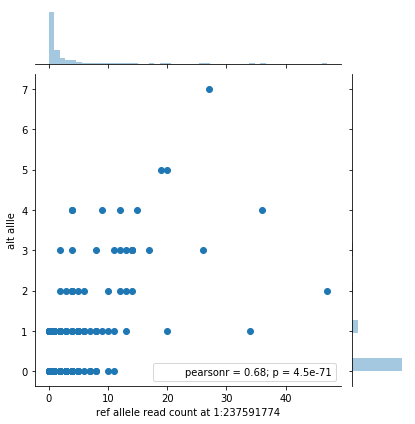

In [293]:
#refBase,altBase
g=sns.jointplot(data=unstackDf['RNA-Seq'],x=refBase,y=altBase)#['G']#['RNA-Seq']
g.set_axis_labels('ref allele read count at {}:{}'.format(queryChr,querySite),'alt allle')

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


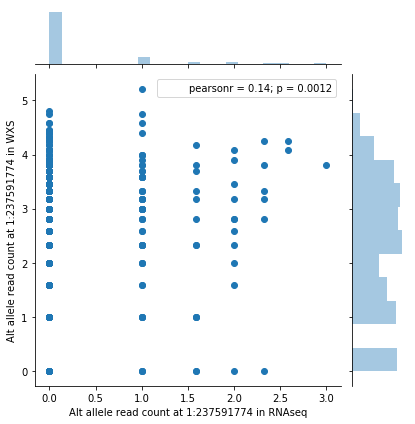

In [300]:
g=sns.jointplot(x=np.log2(unstackDf['RNA-Seq'][altBase]+1),y=np.log2(unstackDf['WXS'][altBase]+1))
g.set_axis_labels('Alt allele read count at {}:{} in RNAseq'.format(queryChr,querySite),
                  'Alt allele read count at {}:{} in WXS'.format(queryChr,querySite))

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


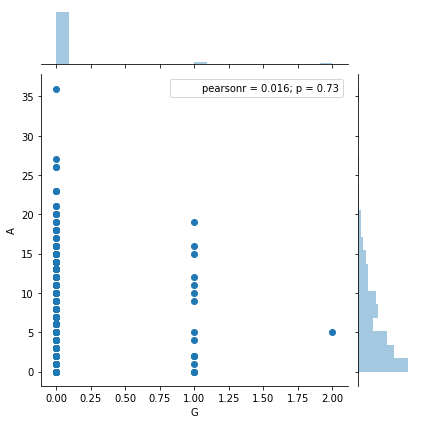

In [295]:
sns.jointplot(data=unstackDf['WXS'],x='G',y='A')

In [296]:
unstackDf['A'].head()

KeyError: 'A'

In [ ]:
sns.jointplot(data=np.log2(unstackDf['A']+1),x=('RNA-Seq'),y=('WXS'))

In [ ]:
unstackDf['WXS'].sum(axis=1)

In [ ]:
manifest_dmanifest_g=manifest_df_w_RNA_WXS.groupby(['sample_barcode','experimental_strategy'])

In [24]:
manifest_df_w_RNA_WXS.set_index('file_id')['experimental_strategy']

file_id
1985b367-00c4-4c25-b049-5858e937cc6d    RNA-Seq
a7aff6a7-cea4-42e9-8d56-b211843a0302    RNA-Seq
4038984b-21d1-45d3-a5bb-208f9e71aa78    RNA-Seq
7b17a5ef-c778-4753-8c30-427af9171f7a    RNA-Seq
93e20db7-4892-4ef8-9331-ecd665e4cb91    RNA-Seq
35a18f9e-0ef8-4e55-b655-33397b63fd1a    RNA-Seq
bc27f71a-4222-4940-8a64-246e2b9f3d44        WXS
84943493-e5ef-4099-8706-09afa625b076        WXS
f36d778a-2c49-43aa-a577-7a6a921ad6cc        WXS
243e9ccb-7c93-4c6a-9e3e-105c379e7f78    RNA-Seq
f895b46c-7811-4ebb-ac9c-970bbfed657a    RNA-Seq
3594993e-f65c-434b-a64e-b1873f4b04ca        WXS
4522becf-1566-4de8-b760-79bb93513ecf        WXS
65c95f19-84f0-4e8b-99c3-186f881181a4    RNA-Seq
eb4dda76-4215-458b-b9a0-60f9ff24bd6e    RNA-Seq
f4db57f0-ba62-4a60-b65d-d2354612eb7b    RNA-Seq
00b53e00-d640-49e5-b2bd-3a3bdf867998    RNA-Seq
e55c8de3-3a92-42f2-bc1e-70a21355d696        WXS
3a0e5ae0-dc79-468d-b459-a6d43b612851        WXS
3011867e-1c3b-4791-849e-4e7d636ddc88    RNA-Seq
fd5d9171-979e-4742-adec-179f19bf